In [38]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import wmfdata as wmf

In [ ]:
traffic_by_platform = wmf.spark.run("""
SELECT
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS dt,
    SUM(IF(access_method = 'mobile app', view_count, 0)) AS app,
    SUM(IF(access_method != 'mobile app', view_count, 0)) AS web
FROM wmf.pageview_hourly    
WHERE
    user_agent_map["os_family"] IN ('KaiOS', 'Firefox OS')
    AND (year = 2018 AND month >= 3 OR year > 2018)
    AND agent_type != 'spider'
GROUP BY
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0'))
""")
    

PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.
[Stage 0:>                                                     (0 + 36) / 10000]22/10/21 03:22:16 WARN NioEventLoop: Selector.select() returned prematurely 512 times in a row; rebuilding Selector io.netty.channel.nio.SelectedSelectionKeySetSelector@74e4653a.
22/10/21 03:23:44 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
[Stage 1:=======>                                        (16484 + 256) / 104254]

In [43]:
mpl.style.use({
    "axes.grid": True,
    "axes.autolimit_mode": "data",
    "font.size": 16,
    "xtick.bottom": False,
    "ytick.left": False,
    "lines.linewidth": 3,
    "figure.figsize": (12, 7),
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "figure.dpi": 300
})

In [48]:
weekly_traffic_by_platform = (
    traffic_by_platform
    .assign(dt=lambda df: pd.to_datetime(df["dt"]))
    .sort_values("dt")
    .set_index("dt")
    .resample("W-MON", label="left")
    .sum()
    # Remove partial weeks at start and end
    .iloc[1:-1]
    # None rather than zero means the graph line isn't extended
    .replace(0, np.NaN)
)

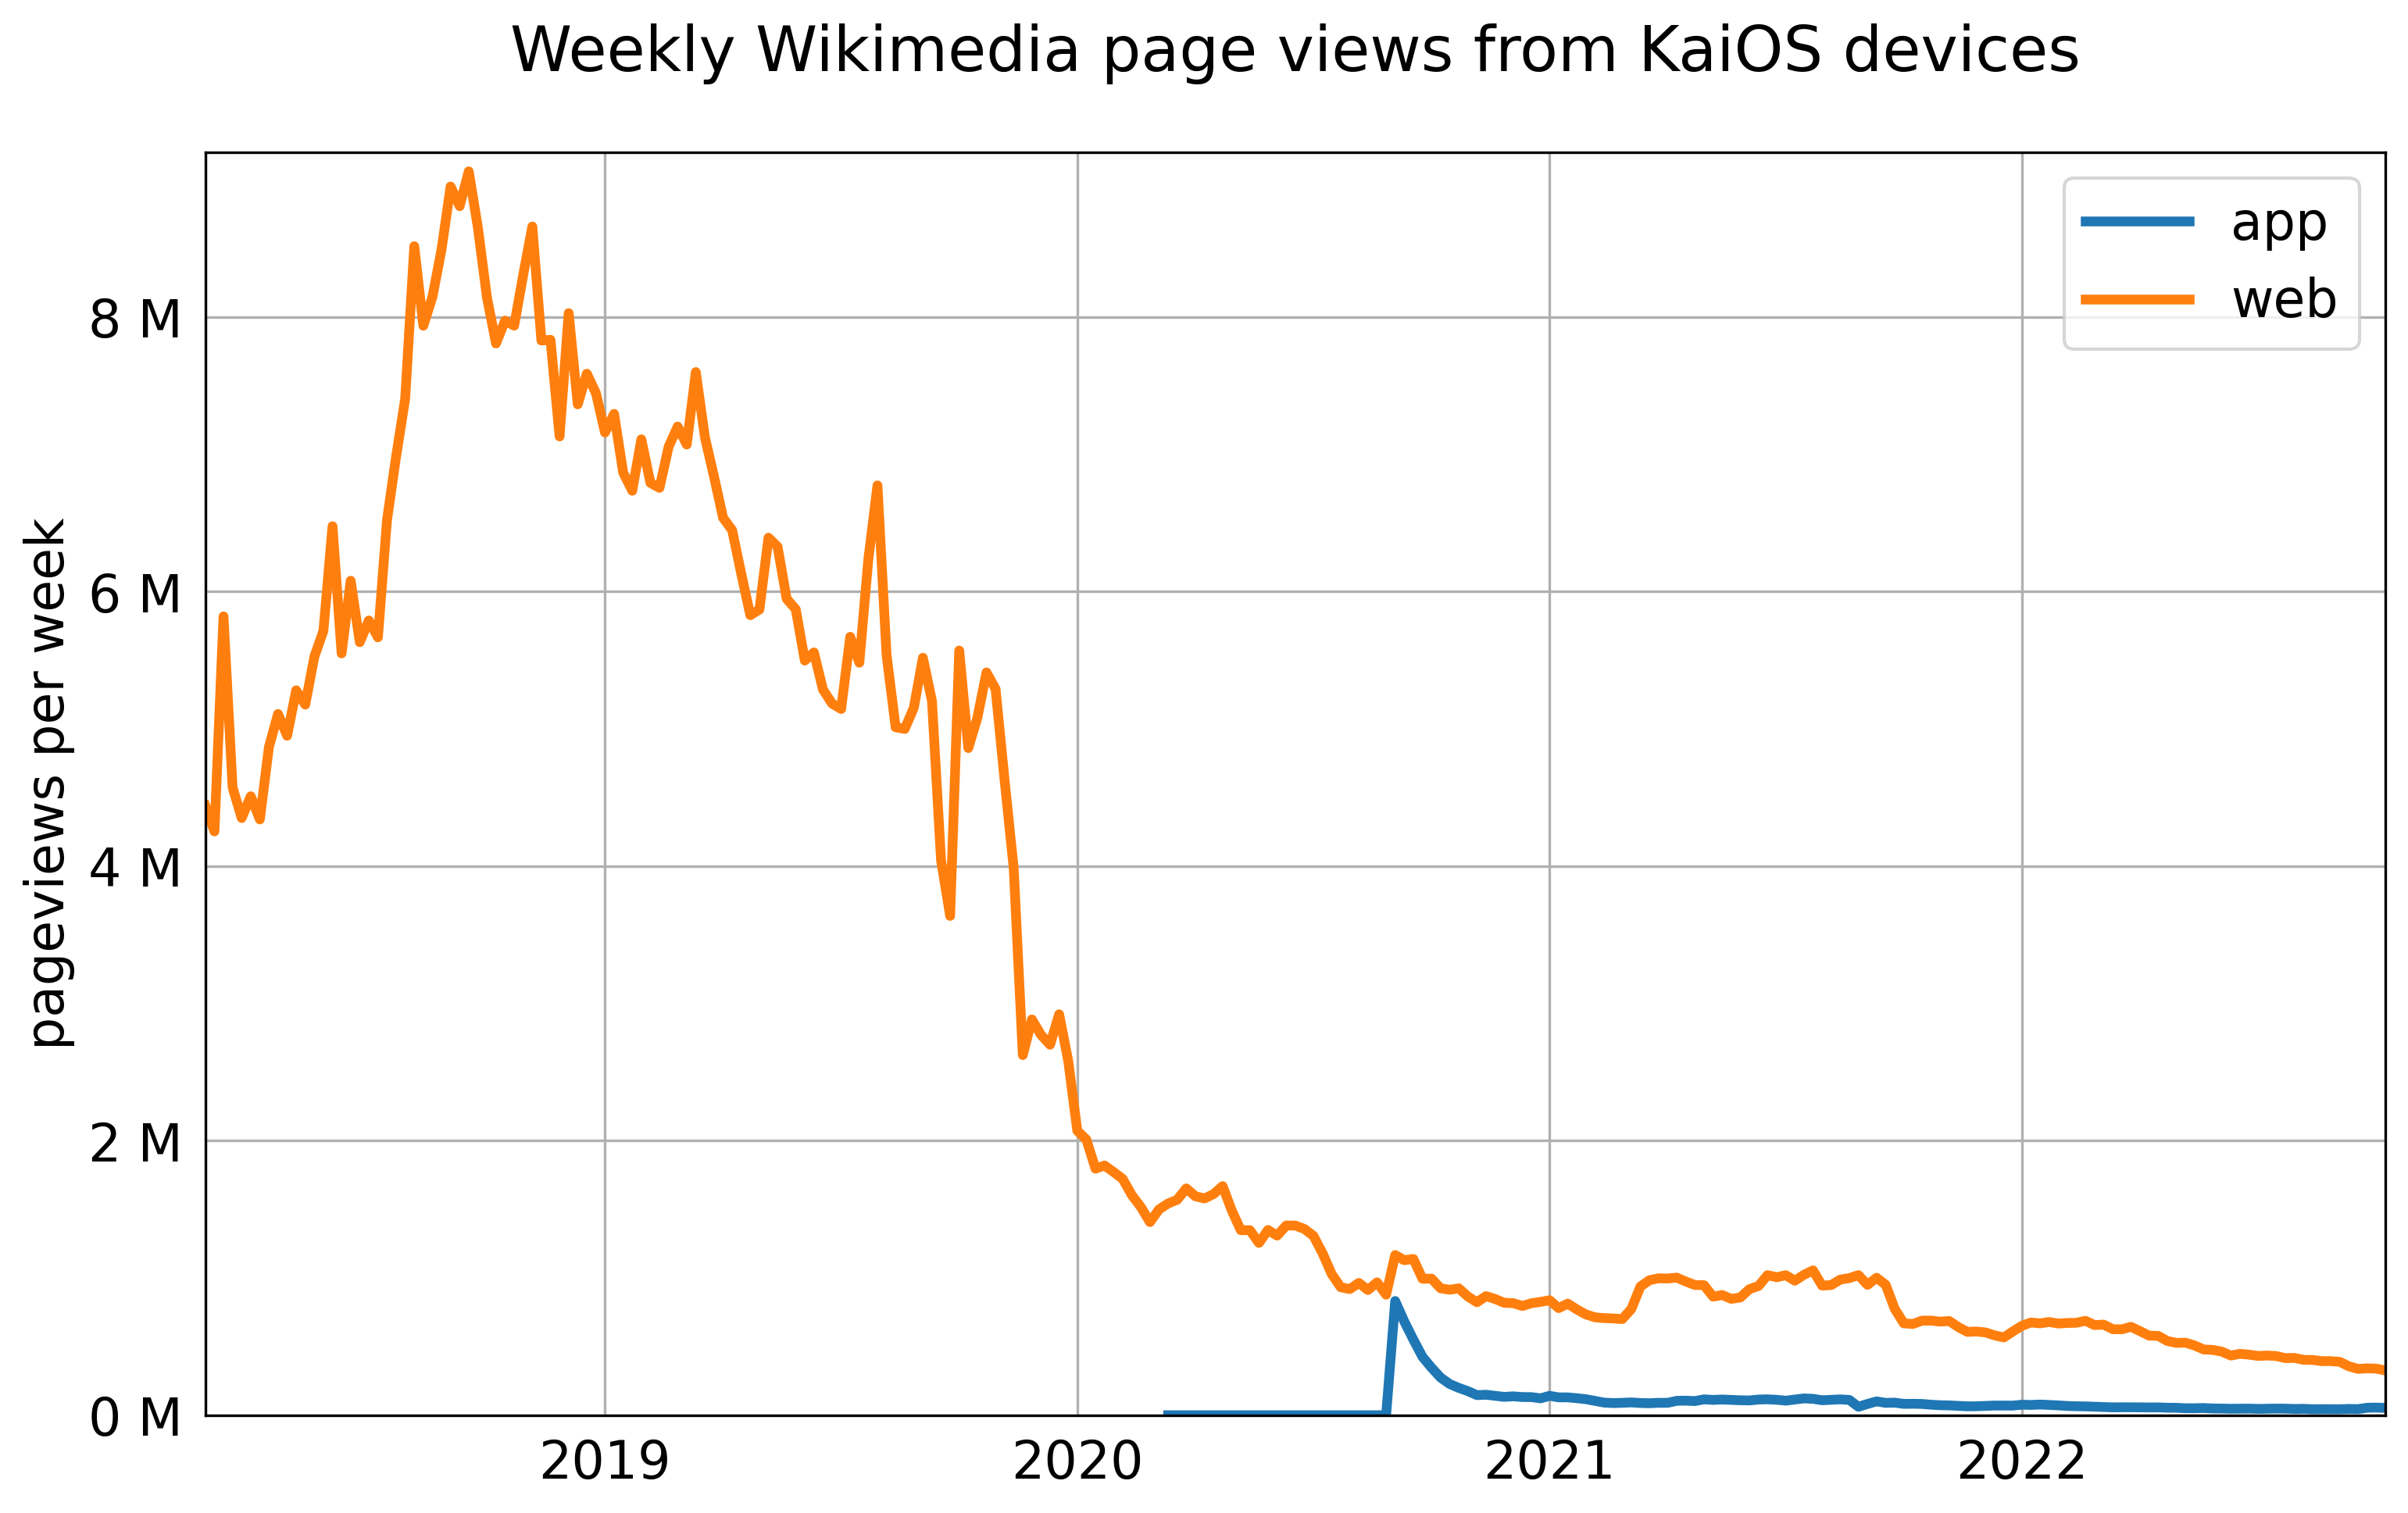

In [72]:
ax = weekly_traffic_by_platform.plot()

def M_str(x, pos):
    n = int(round(x / 1000000))
    return "{n} M".format(n=n)

ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(M_str))

ax.set_ylim((0, 9200000))

ax.set_title("Weekly Wikimedia page views from KaiOS devices", pad=25)
ax.set_xlabel("")
ax.set_ylabel("pageviews per week");

In [58]:
weekly_traffic_by_platform.loc['2018-09': '2018-10']

,app,web
dt,,
2018-09-03,NaN,8489541
2018-09-10,NaN,8949933
2018-09-17,NaN,8806904
2018-09-24,NaN,9060432
2018-10-01,NaN,8653136
2018-10-08,NaN,8143535
2018-10-15,NaN,7806885
2018-10-22,NaN,7973054
2018-10-29,NaN,7936424


In [60]:
weekly_traffic_by_platform.sum(axis=1).tail()

dt
2022-09-12    402388.0
2022-09-19    382043.0
2022-09-26    396081.0
2022-10-03    395083.0
2022-10-10    379900.0
Freq: W-MON, dtype: float64

In [62]:
weekly_traffic_by_platform.assign(
    app_share=lambda df: df["web"] / (df["app"] + df["web"])
).tail()

,app,web,app_share
dt,,,
2022-09-12,45998.0,356390,0.885687
2022-09-19,44489.0,337554,0.883550
2022-09-26,54619.0,341462,0.862101
2022-10-03,55636.0,339447,0.859179
2022-10-10,53498.0,326402,0.859179


In [63]:
daily_traffic_by_platform = (
    traffic_by_platform
    .assign(dt=lambda df: pd.to_datetime(df["dt"]))
    .sort_values("dt")
    .set_index("dt")
    # Remove partial days at start and end
    .iloc[1:-1]
    # None rather than zero means the graph line isn't extended
    .replace(0, np.NaN)
)

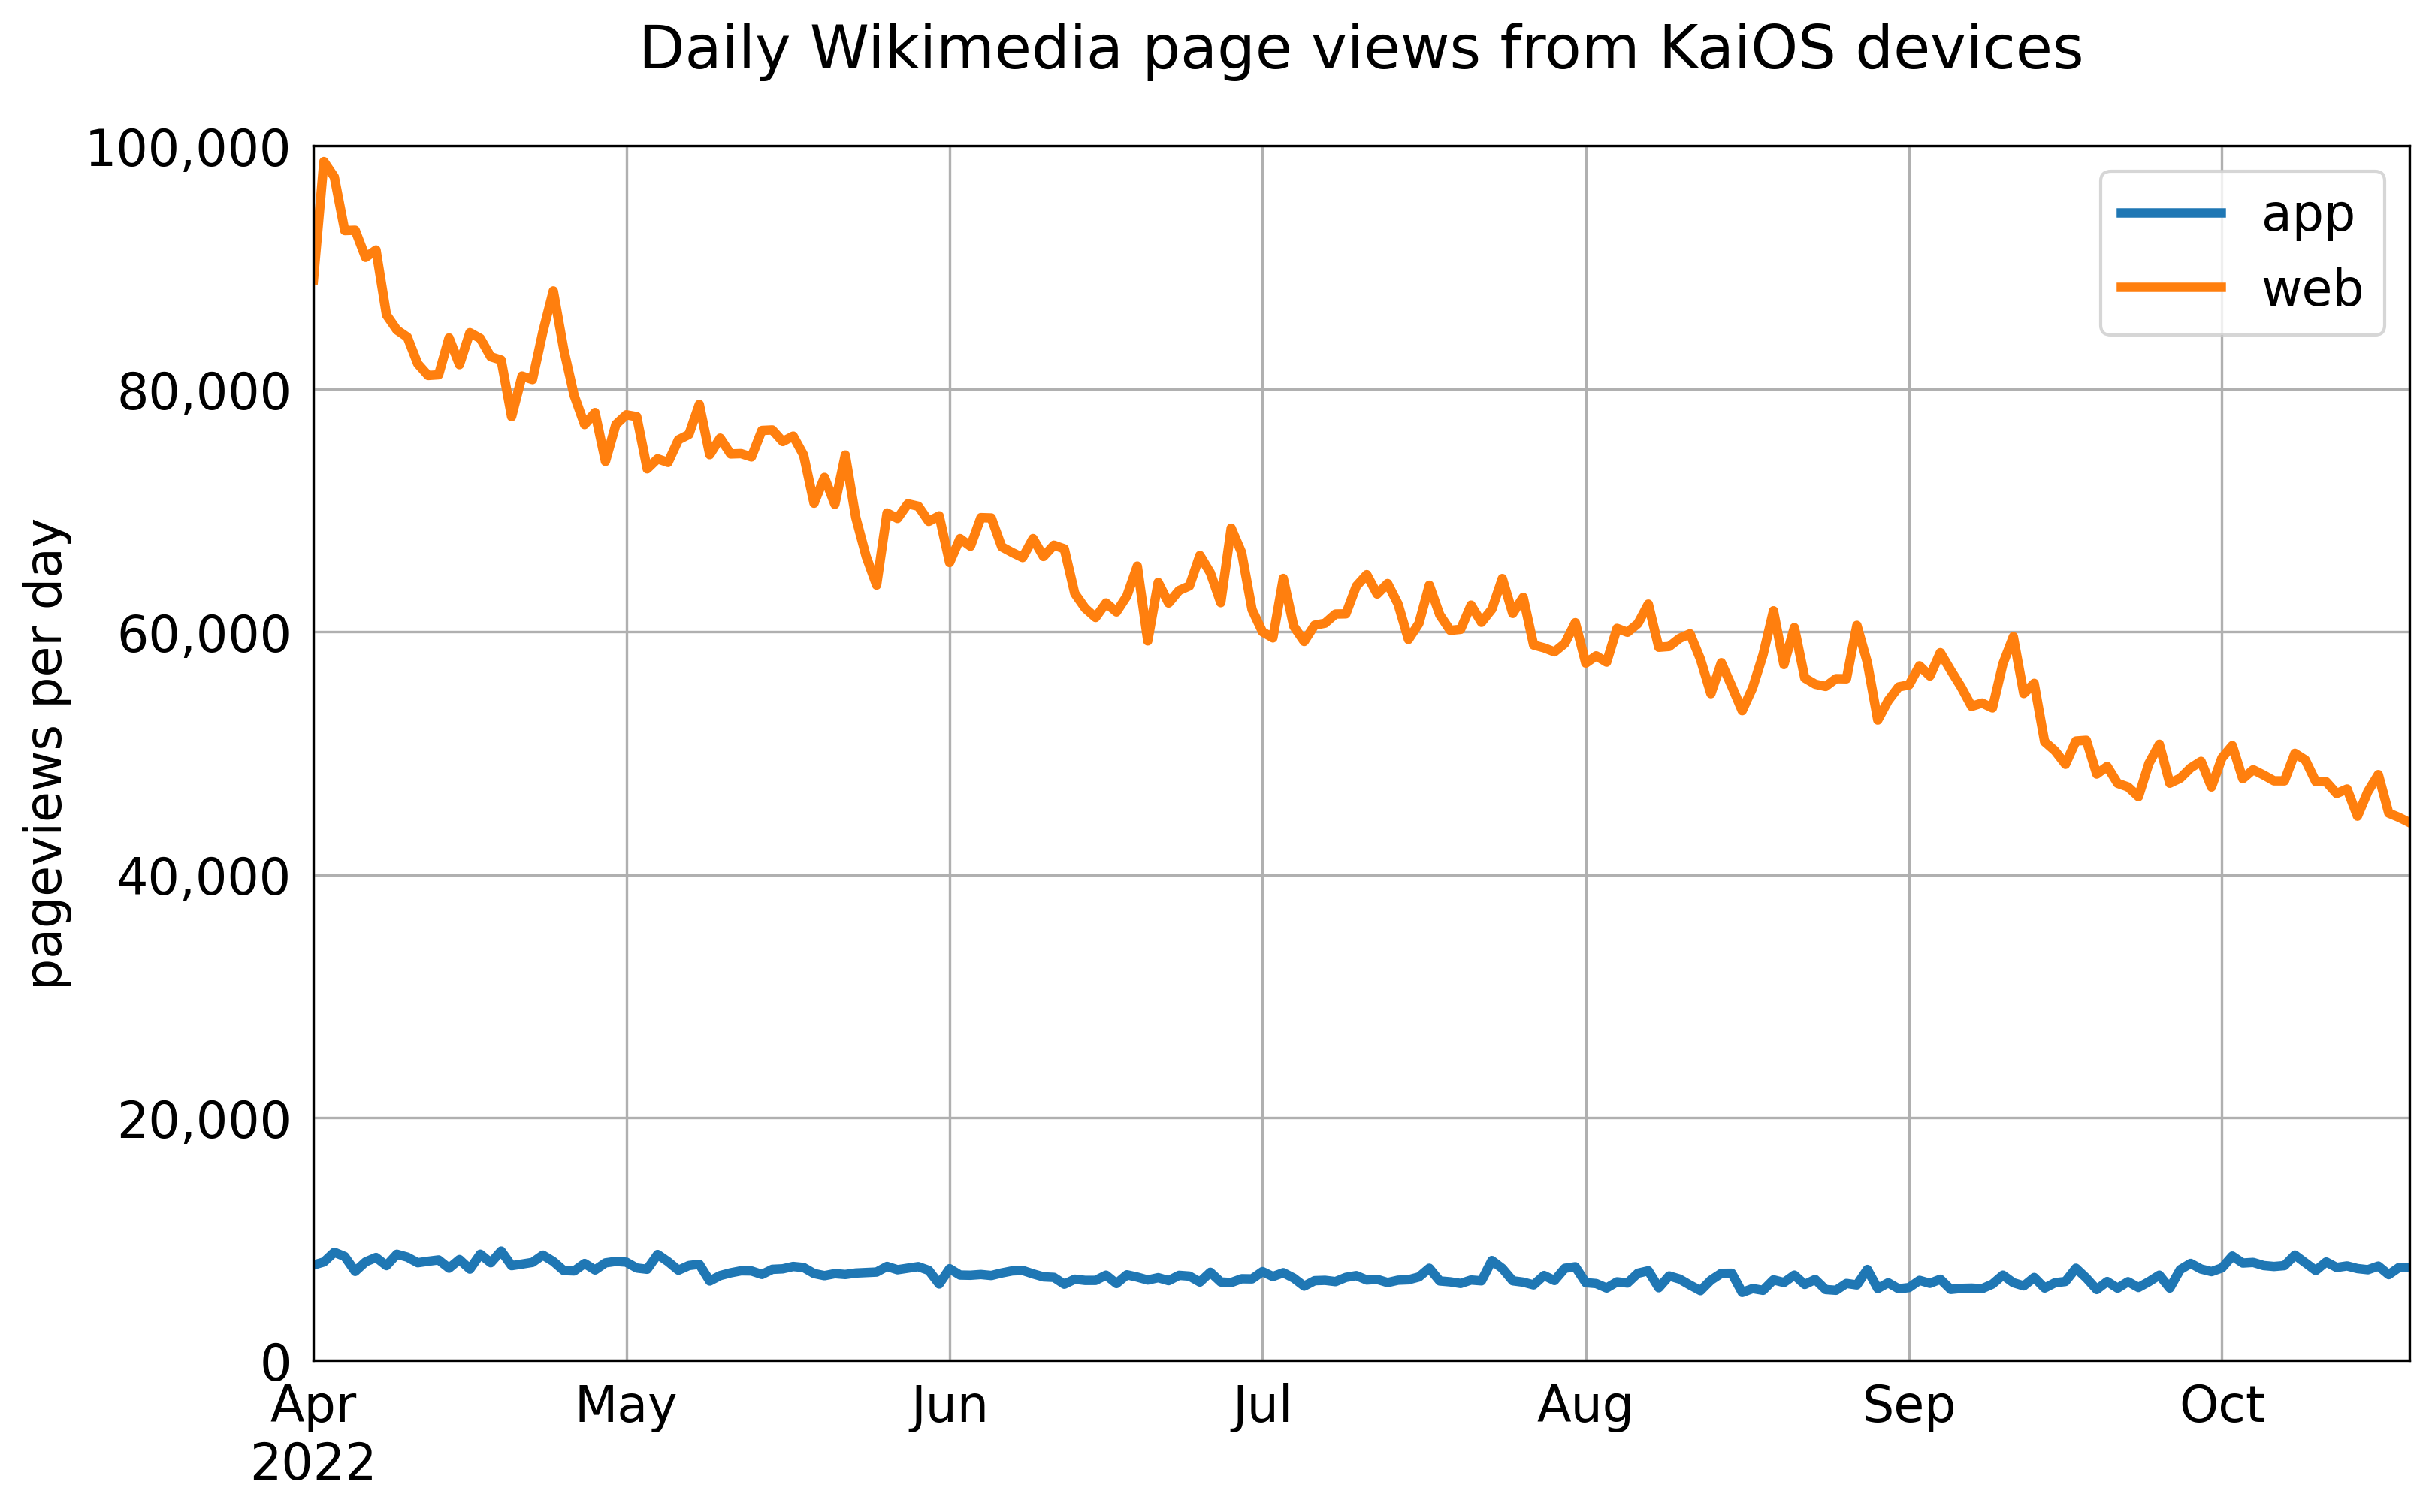

In [73]:
ax = daily_traffic_by_platform.loc["2022-04":].plot()

def M_str(x, pos):
    n = int(round(x / 1000000))
    return "{n} M".format(n=n)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylim((0, 100000))

ax.set_title("Daily Wikimedia page views from KaiOS devices", pad=25)
ax.set_xlabel("")
ax.set_ylabel("pageviews per day");

In [74]:
daily_traffic_by_platform.tail()

,app,web
dt,,
2022-10-15,7480.0,46853
2022-10-16,7781.0,48251
2022-10-17,7078.0,45074
2022-10-18,7675.0,44717
2022-10-19,7665.0,44289


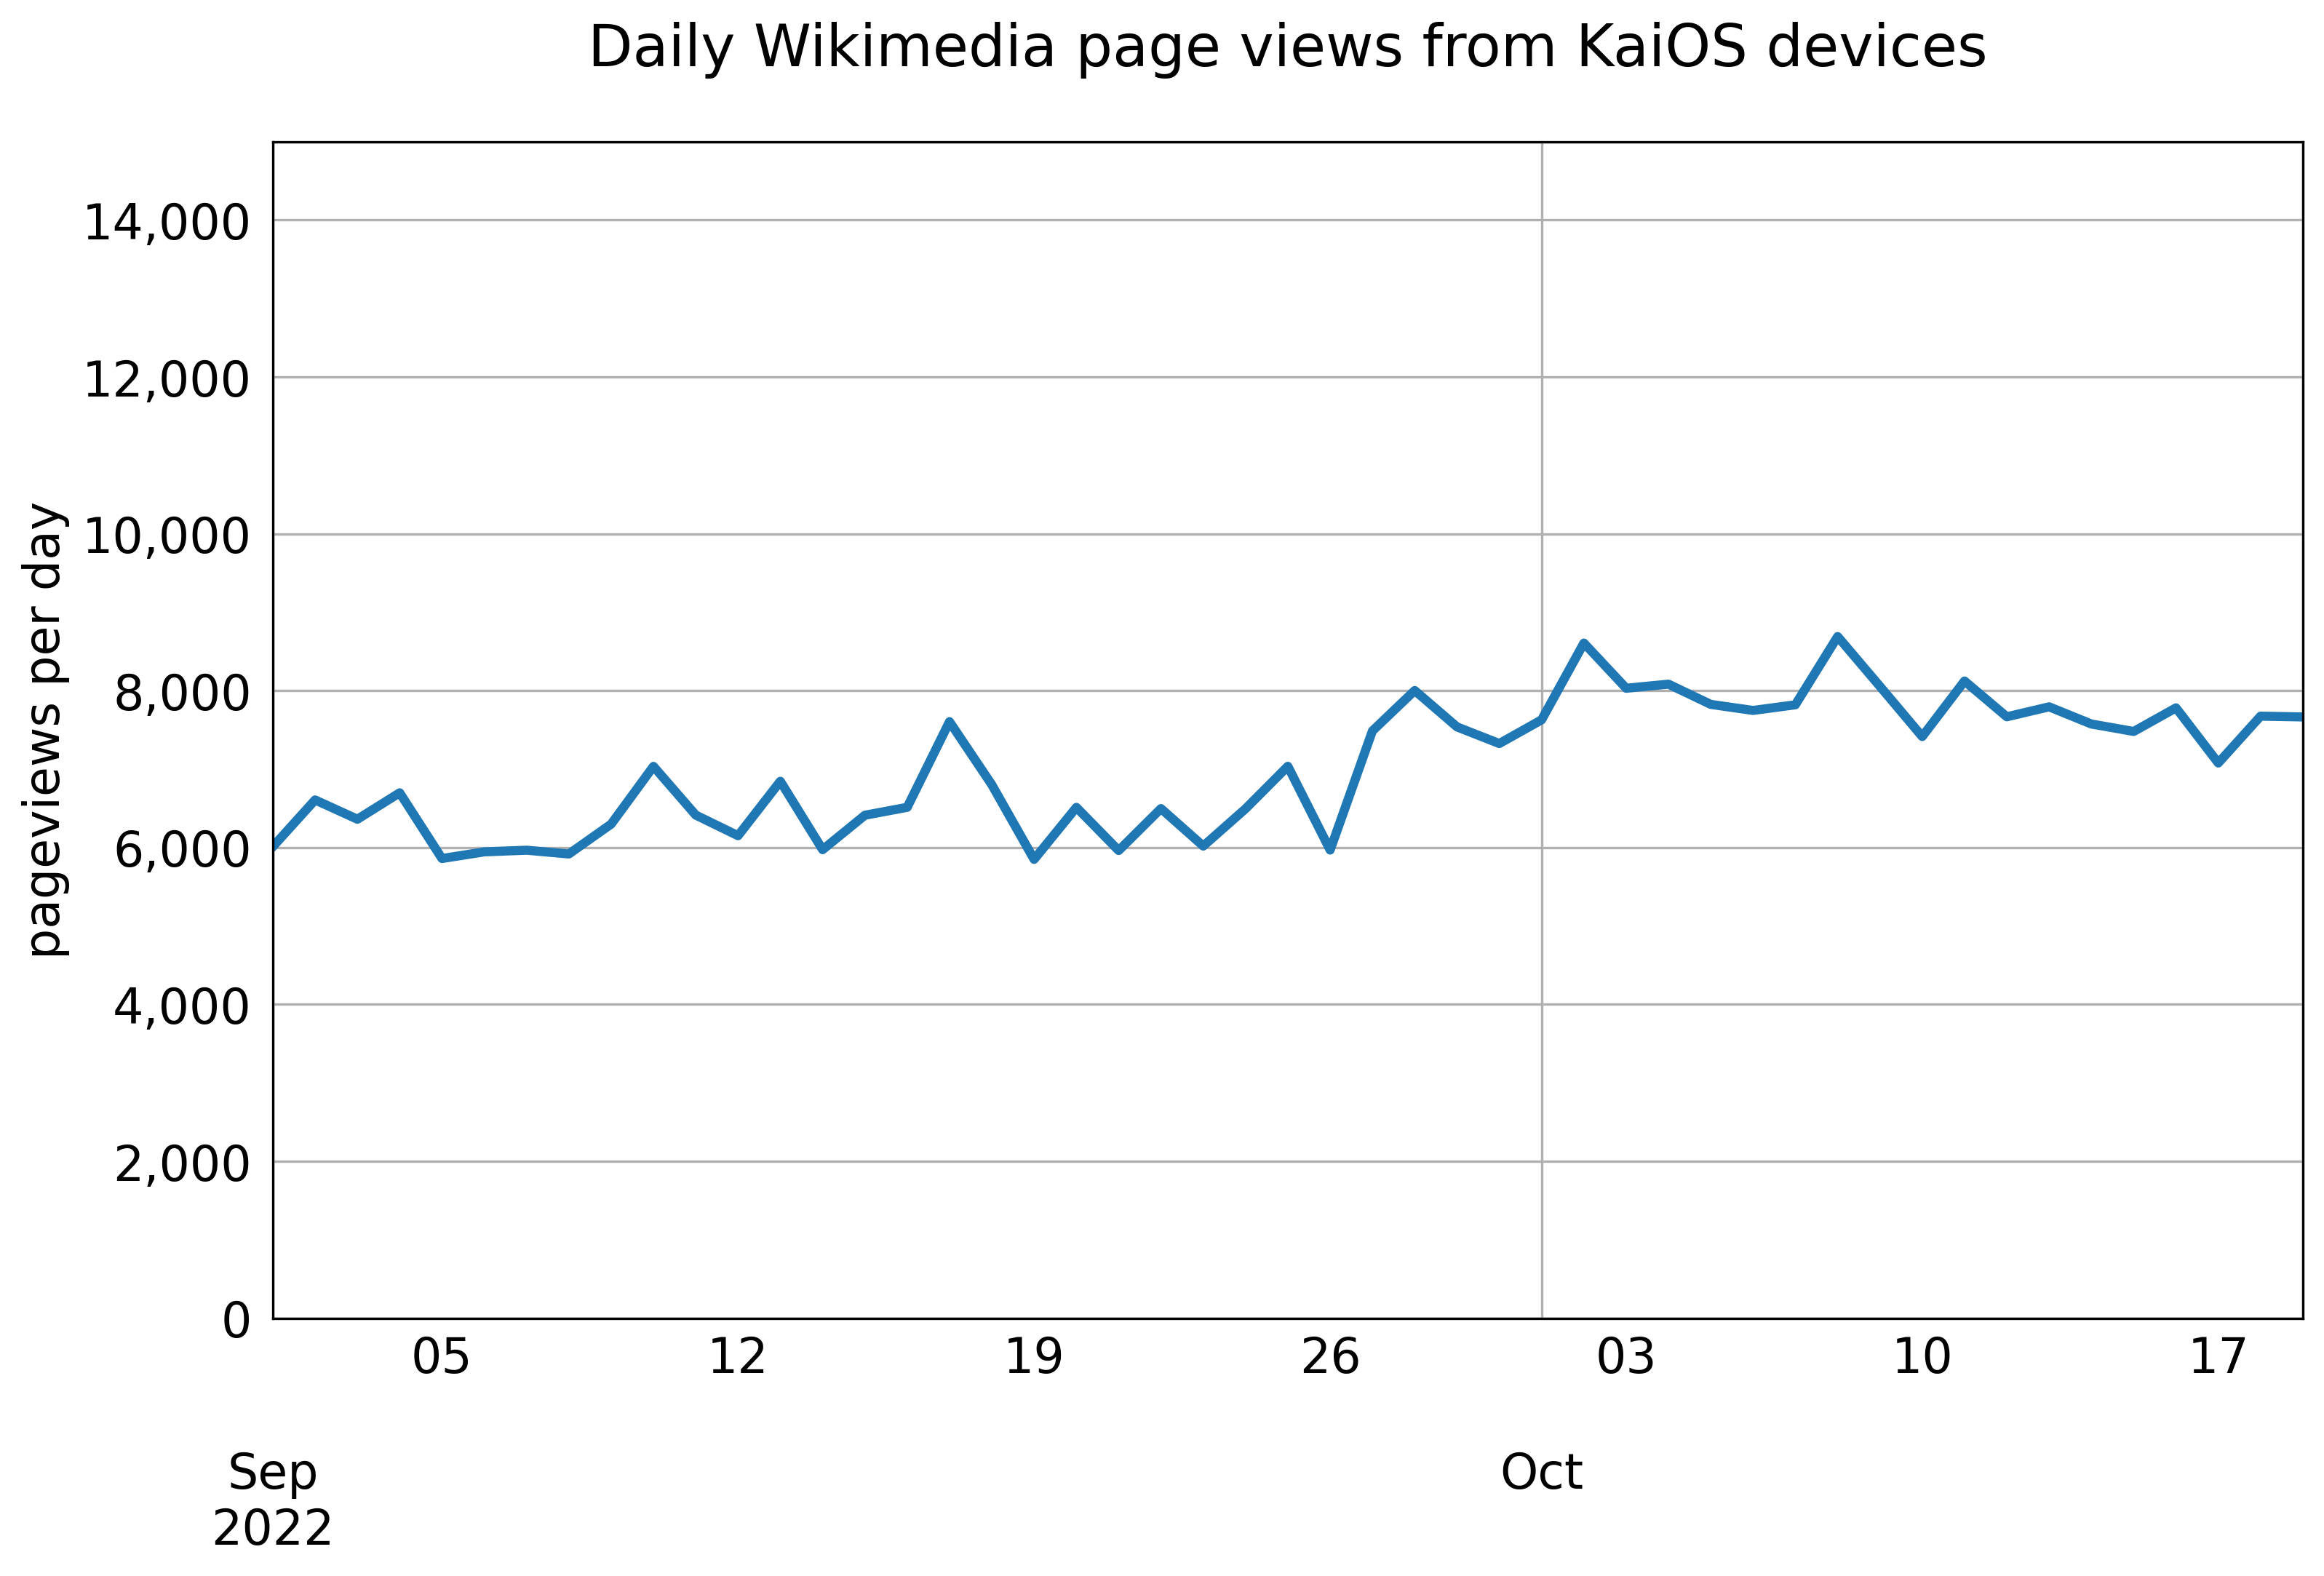

In [102]:
ax = daily_traffic_by_platform.loc["2022-09":, "app"].plot()

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylim((0, 15000))

ax.set_title("Daily Wikimedia page views from KaiOS devices", pad=25)
ax.set_xlabel("")
ax.set_ylabel("pageviews per day");

In [96]:
user = wmf.spark.run(
    """
    WITH app_user AS (
        SELECT
            DATE_TRUNC('DAY', TO_TIMESTAMP(ipv.dt)) AS dt,
            ipv.event.user_id AS user_id,
            IF(
                SIZE(SPLIT(FIRST(ipv.event.app_version), '\\\\.')) = 3,
                'KaiStore',
                'JioStore'
            ) AS store,
            IF(
                DATE_TRUNC('DAY', TO_TIMESTAMP(ipv.dt)) = DATE_TRUNC('DAY', TO_TIMESTAMP(FIRST(kafr.dt))),
                'first-time',
                'returning'
            ) AS user_type
        FROM event.inukapageview ipv
        LEFT JOIN event_sanitized.kaiosappfirstrun kafr
        ON ipv.event.user_id = kafr.event.app_id
        WHERE
            ipv.event.client_type = 'kaios-app'
            AND DATE_TRUNC('day', TO_TIMESTAMP(ipv.dt)) < CURRENT_DATE
    GROUP BY
        DATE_TRUNC('DAY', TO_TIMESTAMP(ipv.dt)),
        ipv.event.user_id
    )
    SELECT
        dt,
        store,
        user_type,
        COUNT(*) AS users
    FROM app_user
    GROUP BY
        dt,
        store,
        user_type
    ORDER BY
        dt,
        store,
        user_type
    LIMIT 100000
    """,
    session_type="yarn-large"
)

PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


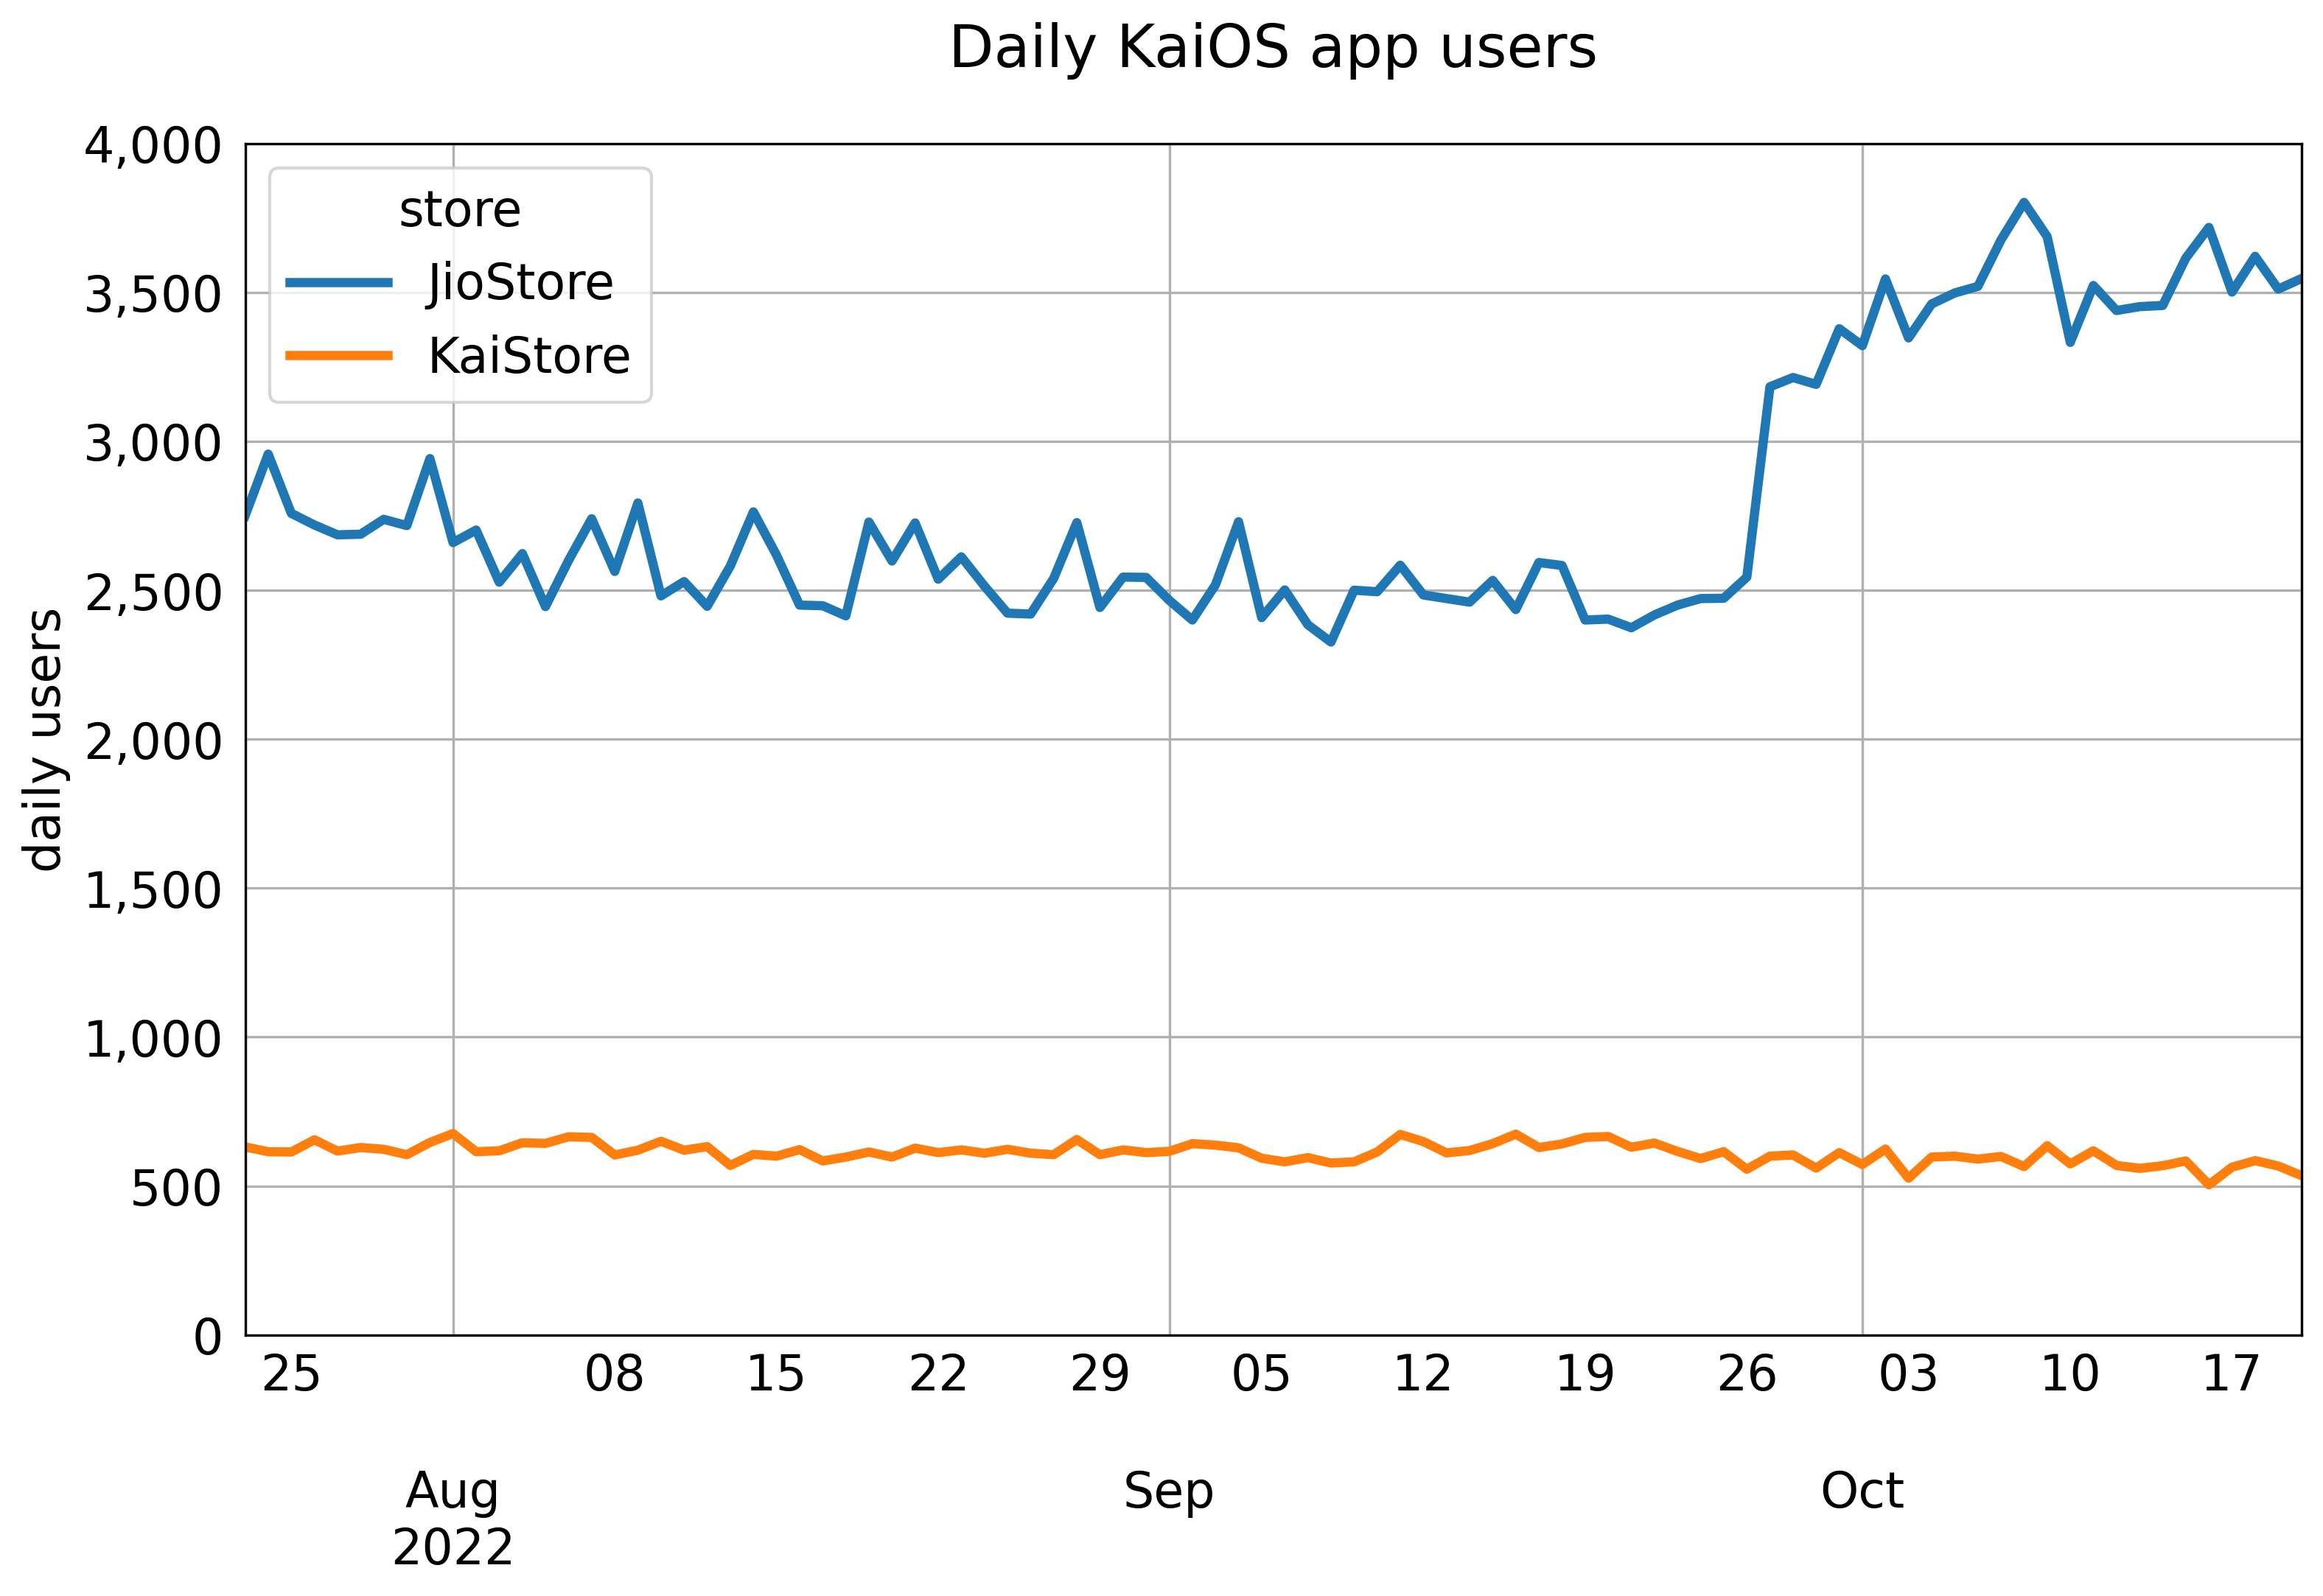

In [104]:
ax = (
    user
    .groupby(["dt", "store"])
    ["users"].sum()
    .unstack()
    .plot()
)


ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylim((0, 4000))

ax.set_title("Daily KaiOS app users", pad=25)
ax.set_xlabel("")
ax.set_ylabel("daily users");

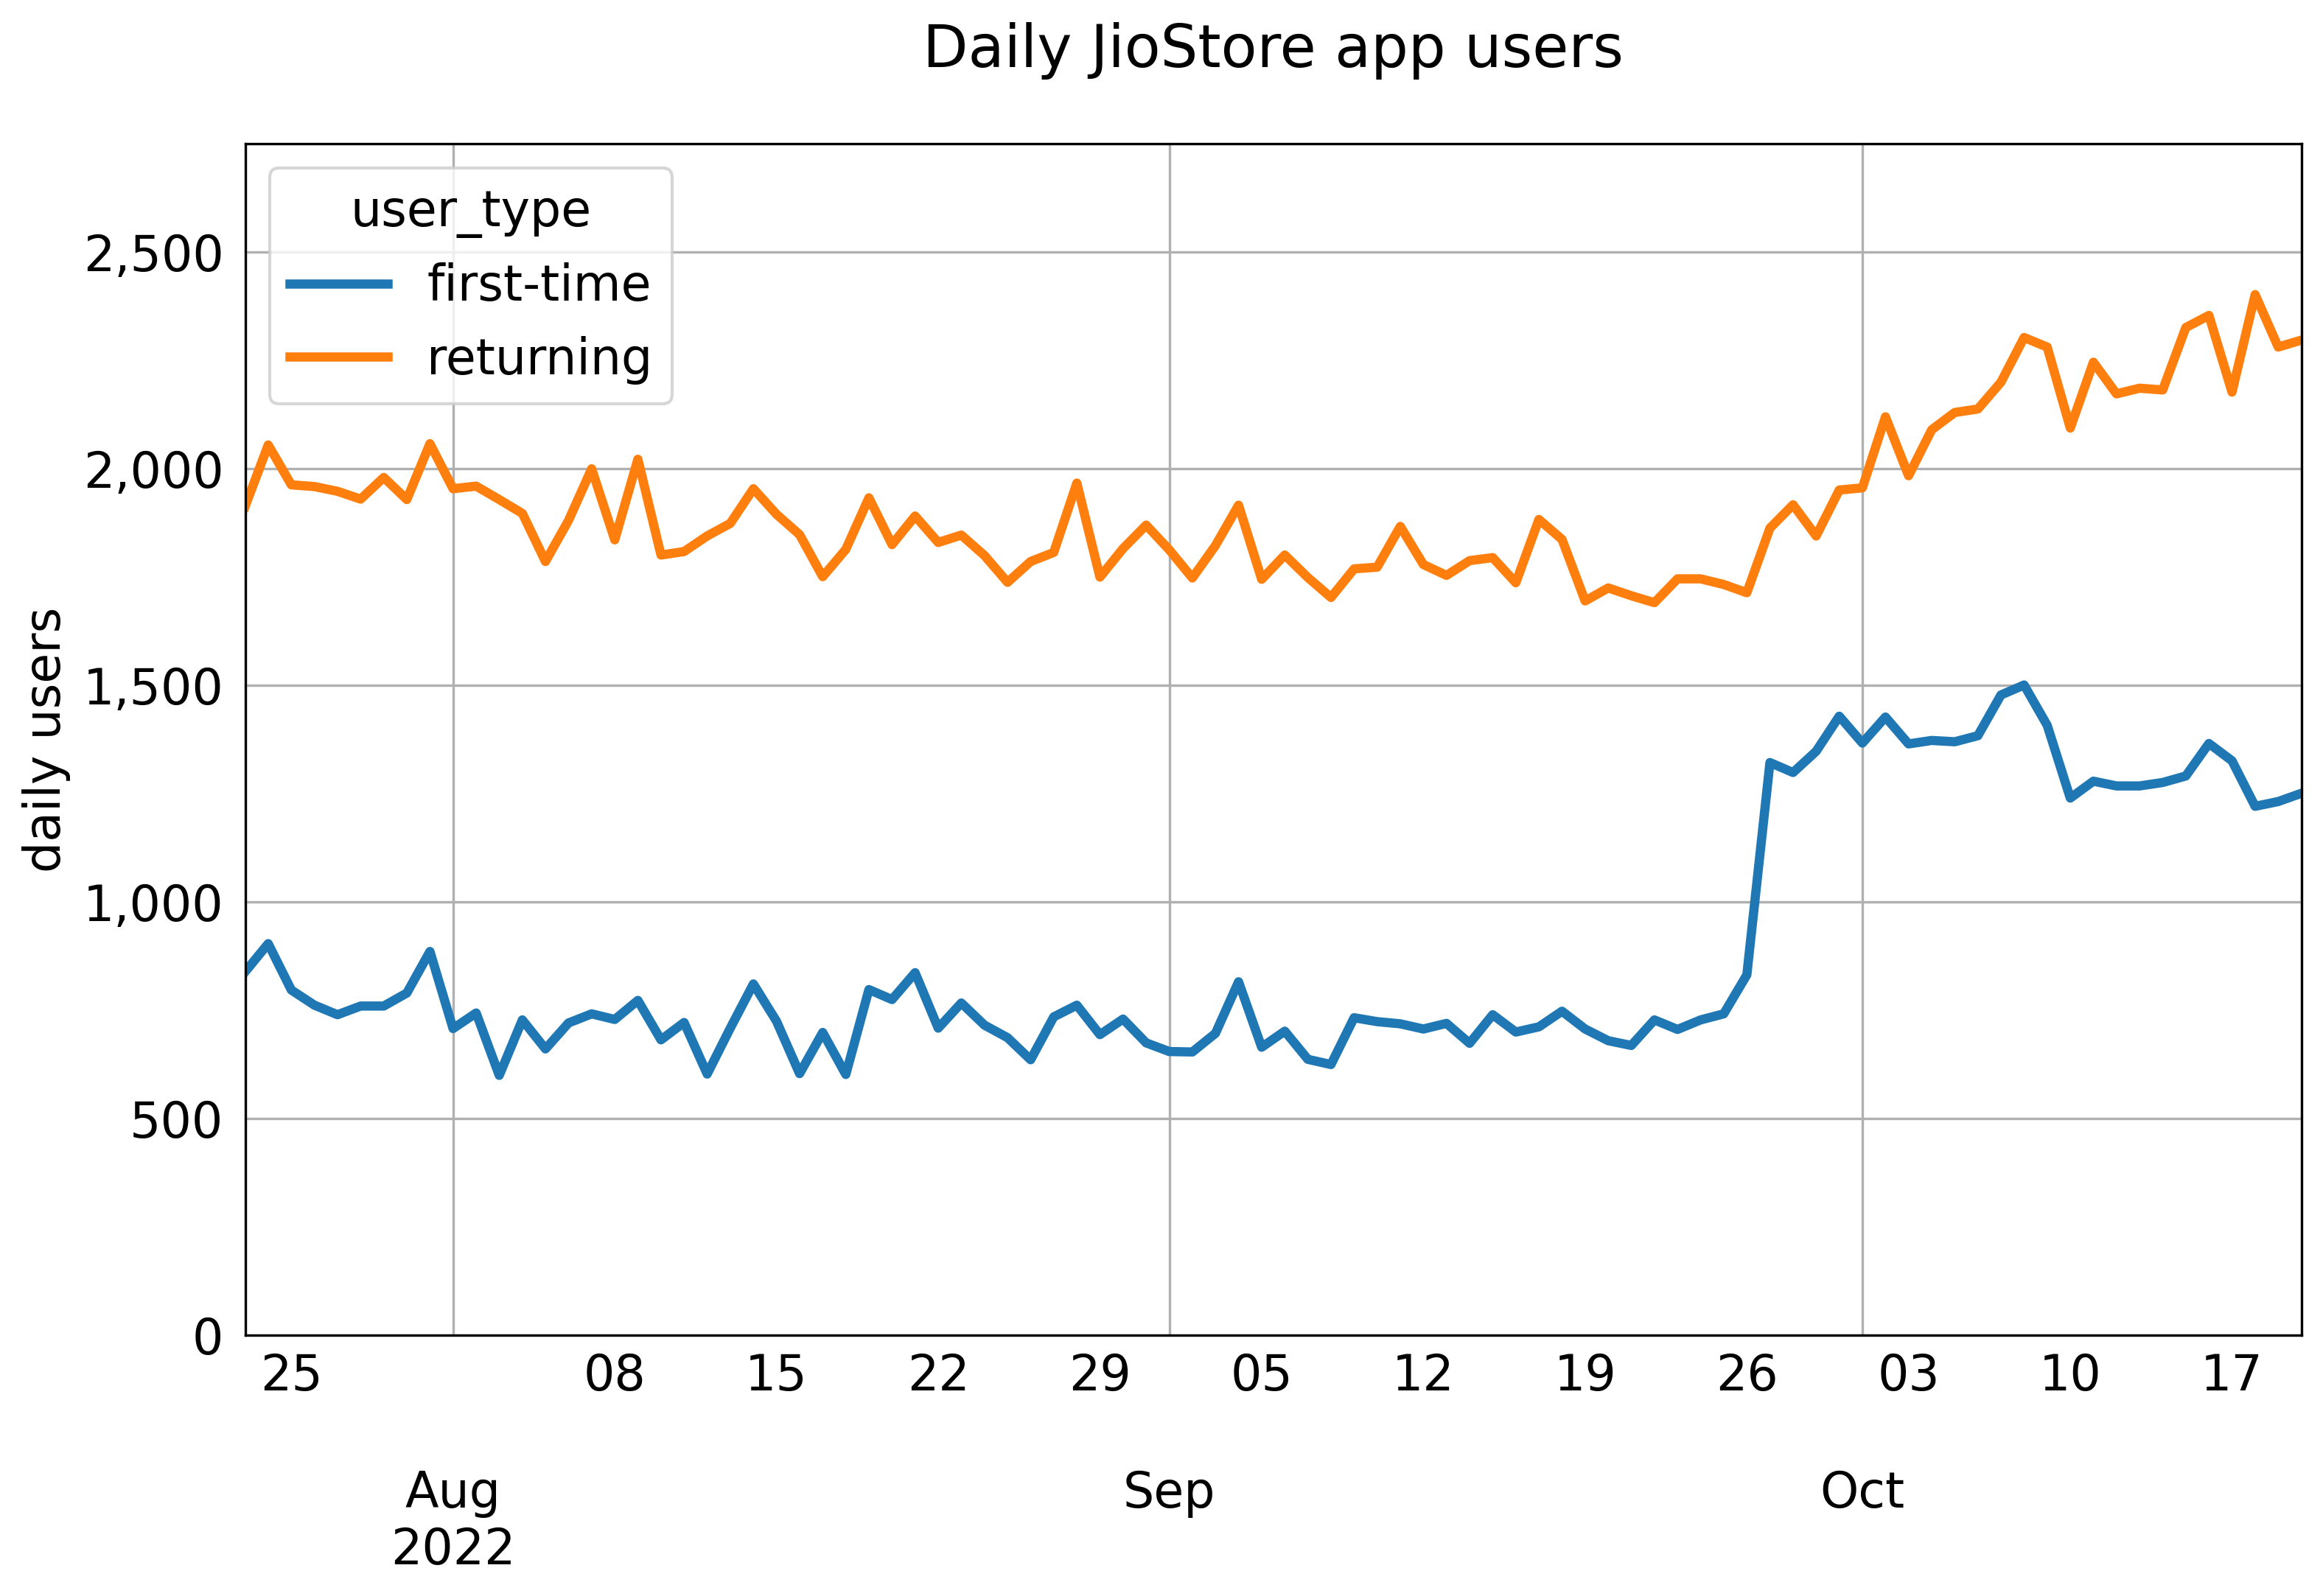

In [117]:
ax = (
    user
    .query("store == 'JioStore'")
    .drop(columns="store")
    .set_index("dt")
    .pivot(columns="user_type")
    .droplevel(0, axis="columns")
    .plot()
)


ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylim((0, 2750))

ax.set_title("Daily JioStore app users", pad=25)
ax.set_xlabel("")
ax.set_ylabel("daily users");

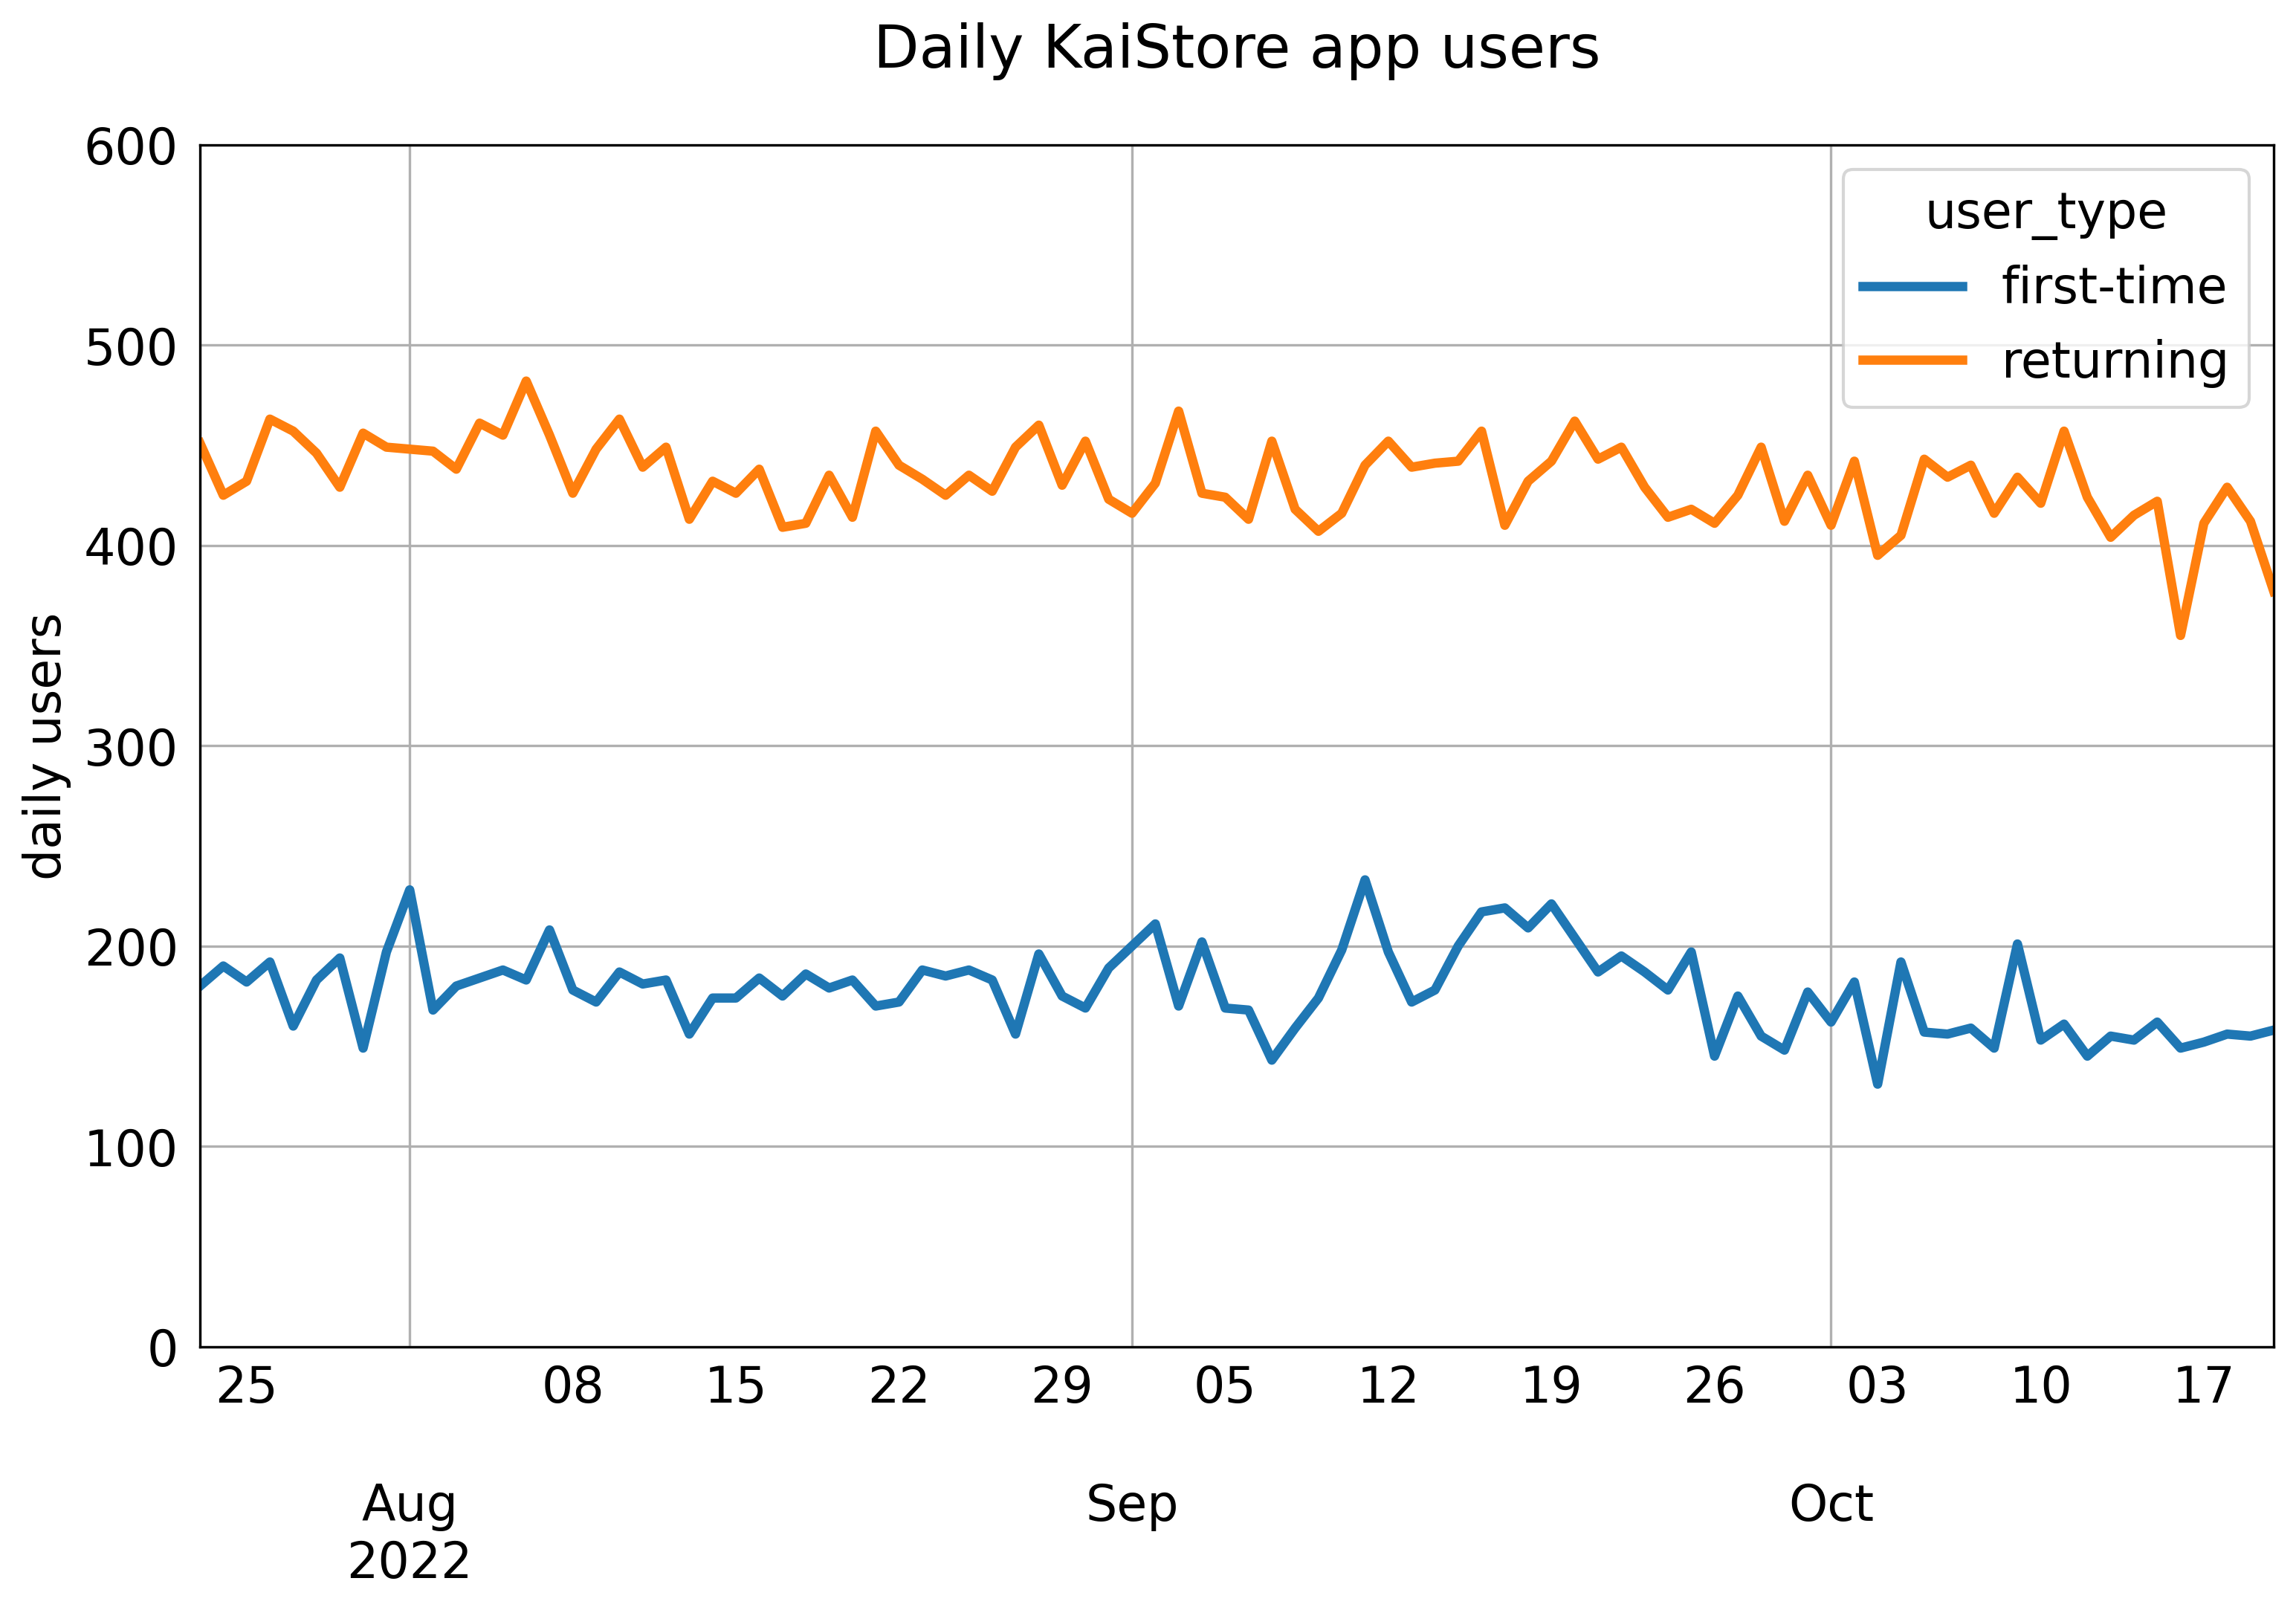

In [120]:
ax = (
    user
    .query("store == 'KaiStore'")
    .drop(columns="store")
    .set_index("dt")
    .pivot(columns="user_type")
    .droplevel(0, axis="columns")
    .plot()
)


ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylim((0, 600))

ax.set_title("Daily KaiStore app users", pad=25)
ax.set_xlabel("")
ax.set_ylabel("daily users");